In [1]:
%%time
import tensorflow as tf
tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']
Num GPUs Available:  1
Wall time: 8.33 s


In [2]:
#!pip install -U keras-tuner

In [13]:
import sys
import os
import keras
import tensorflow as tf
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix,classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Flatten, Dense, Activation, merge
from keras.layers import MaxPooling2D,Dense,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.regularizers import l2
from keras.utils import multi_gpu_model
from keras.layers.normalization import BatchNormalization
from keras import callbacks
from keras.callbacks import ModelCheckpoint
import time
import json
start = time.time()
from kerastuner import HyperModel, Objective
from kerastuner.tuners import BayesianOptimization

from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from matplotlib import pyplot as plt

In [4]:
#akses data
train_data_path = r'C:\Users\Julius Chris\Desktop\data_skripsi\training'
test_data_path = r'C:\Users\Julius Chris\Desktop\data_skripsi\testing'
valid_data_path = r'C:\Users\Julius Chris\Desktop\data_skripsi\validation'

In [5]:
"""
Parameters
"""
img_width, img_height = 224,224
batch_size = 32
samples_per_epoch = 100
validation_steps = 100
pool_size = 3
classes_num = 5
lr = 0.001

In [18]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=((6, 6)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig('img/' + title + '.png')


In [6]:
augs_gen = ImageDataGenerator(
                rescale=1. / 255,
                #rescale=None,
                #shear_range=0.2,
                #zoom_range=0.2,
                rotation_range=.3,
                #width_shift_range=.15,
                #height_shift_range=.15,
                vertical_flip=True,
                horizontal_flip=True,
)  

train_generator = augs_gen.flow_from_directory(
        train_data_path,
        target_size = (img_height, img_width),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
)

validation_generator = augs_gen.flow_from_directory(
      valid_data_path,
      target_size = (img_height, img_width),
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle = False,
)

testing_generator = augs_gen.flow_from_directory(
      test_data_path,
      target_size = (img_height, img_width),
      class_mode = 'categorical',
      shuffle = False
)

Found 3238 images belonging to 5 classes.
Found 606 images belonging to 5 classes.
Found 205 images belonging to 5 classes.


# BEFORE TUNING MODEL

In [27]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.build()
model.summary()

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 48)      38448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 139968)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               35832064  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='lenet_pretuned.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [29]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [30]:
filepath = "lenet_pretuned.h5"
checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list = [checkpoint]

In [31]:
%%time
history = model.fit(train_generator, 
                  steps_per_epoch=50, 
                  epochs=200,
                  validation_data=validation_generator, 
                  validation_steps=10,
                  callbacks=callbacks_list)

Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 1.4655 - accuracy: 0.3638
Epoch 00001: val_accuracy improved from -inf to 0.54688, saving model to lenet_pretuned.h5
50/50 [==============================] - 18s 368ms/step - loss: 1.4655 - accuracy: 0.3638 - val_loss: 1.0345 - val_accuracy: 0.5469
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 1.2694 - accuracy: 0.4809
Epoch 00002: val_accuracy improved from 0.54688 to 0.56250, saving model to lenet_pretuned.h5
50/50 [==============================] - 17s 346ms/step - loss: 1.2694 - accuracy: 0.4809 - val_loss: 1.0157 - val_accuracy: 0.5625
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.5146
Epoch 00003: val_accuracy improved from 0.56250 to 0.72812, saving model to lenet_pretuned.h5
50/50 [==============================] - 17s 346ms/step - loss: 1.1975 - accuracy: 0.5146 - val_loss: 0.8671 - val_accuracy: 0.7281
Epoch 4/200
50/50 [=====================

Epoch 29/200
50/50 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.7732
Epoch 00029: val_accuracy did not improve from 0.85625
50/50 [==============================] - 17s 343ms/step - loss: 0.6454 - accuracy: 0.7732 - val_loss: 0.4892 - val_accuracy: 0.8281
Epoch 30/200
50/50 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.7668
Epoch 00030: val_accuracy did not improve from 0.85625
50/50 [==============================] - 17s 335ms/step - loss: 0.6879 - accuracy: 0.7668 - val_loss: 0.4983 - val_accuracy: 0.8094
Epoch 31/200
50/50 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.7795
Epoch 00031: val_accuracy did not improve from 0.85625
50/50 [==============================] - 17s 332ms/step - loss: 0.6502 - accuracy: 0.7795 - val_loss: 0.4678 - val_accuracy: 0.8125
Epoch 32/200
50/50 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.7757
Epoch 00032: val_accuracy did not improve from 0.85625


Epoch 58/200
50/50 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.8418
Epoch 00058: val_accuracy did not improve from 0.89062
50/50 [==============================] - 17s 331ms/step - loss: 0.4750 - accuracy: 0.8418 - val_loss: 0.3684 - val_accuracy: 0.8719
Epoch 59/200
50/50 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8413
Epoch 00059: val_accuracy did not improve from 0.89062
50/50 [==============================] - 18s 353ms/step - loss: 0.4457 - accuracy: 0.8413 - val_loss: 0.3653 - val_accuracy: 0.8750
Epoch 60/200
50/50 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8687
Epoch 00060: val_accuracy did not improve from 0.89062
50/50 [==============================] - 17s 345ms/step - loss: 0.3980 - accuracy: 0.8687 - val_loss: 0.3610 - val_accuracy: 0.8781
Epoch 61/200
50/50 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8525
Epoch 00061: val_accuracy did not improve from 0.89062


Epoch 87/200
50/50 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.8806
Epoch 00087: val_accuracy did not improve from 0.90312
50/50 [==============================] - 17s 337ms/step - loss: 0.3688 - accuracy: 0.8806 - val_loss: 0.2401 - val_accuracy: 0.9031
Epoch 88/200
50/50 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8744
Epoch 00088: val_accuracy did not improve from 0.90312
50/50 [==============================] - 17s 337ms/step - loss: 0.3487 - accuracy: 0.8744 - val_loss: 0.4021 - val_accuracy: 0.8562
Epoch 89/200
50/50 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8850
Epoch 00089: val_accuracy did not improve from 0.90312
50/50 [==============================] - 17s 336ms/step - loss: 0.3384 - accuracy: 0.8850 - val_loss: 0.3284 - val_accuracy: 0.9000
Epoch 90/200
50/50 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8856
Epoch 00090: val_accuracy did not improve from 0.90312


Epoch 116/200
50/50 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9106
Epoch 00116: val_accuracy did not improve from 0.90625
50/50 [==============================] - 17s 338ms/step - loss: 0.2683 - accuracy: 0.9106 - val_loss: 0.2384 - val_accuracy: 0.9000
Epoch 117/200
50/50 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9111
Epoch 00117: val_accuracy improved from 0.90625 to 0.91562, saving model to lenet_pretuned.h5
50/50 [==============================] - 18s 367ms/step - loss: 0.2645 - accuracy: 0.9111 - val_loss: 0.2768 - val_accuracy: 0.9156
Epoch 118/200
50/50 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9168
Epoch 00118: val_accuracy did not improve from 0.91562
50/50 [==============================] - 17s 336ms/step - loss: 0.2504 - accuracy: 0.9168 - val_loss: 0.2720 - val_accuracy: 0.9000
Epoch 119/200
50/50 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9072
Epoch 00119:

Epoch 145/200
50/50 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9244
Epoch 00145: val_accuracy did not improve from 0.92188
50/50 [==============================] - 17s 336ms/step - loss: 0.2239 - accuracy: 0.9244 - val_loss: 0.2500 - val_accuracy: 0.8875
Epoch 146/200
50/50 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9250
Epoch 00146: val_accuracy did not improve from 0.92188
50/50 [==============================] - 17s 335ms/step - loss: 0.2301 - accuracy: 0.9250 - val_loss: 0.2775 - val_accuracy: 0.8938
Epoch 147/200
50/50 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9169
Epoch 00147: val_accuracy did not improve from 0.92188
50/50 [==============================] - 17s 334ms/step - loss: 0.2547 - accuracy: 0.9169 - val_loss: 0.2524 - val_accuracy: 0.9094
Epoch 148/200
50/50 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9419
Epoch 00148: val_accuracy did not improve from 0.92

Epoch 174/200
50/50 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9438
Epoch 00174: val_accuracy did not improve from 0.92813
50/50 [==============================] - 17s 336ms/step - loss: 0.1755 - accuracy: 0.9438 - val_loss: 0.2587 - val_accuracy: 0.9031
Epoch 175/200
50/50 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9327
Epoch 00175: val_accuracy did not improve from 0.92813
50/50 [==============================] - 17s 337ms/step - loss: 0.1838 - accuracy: 0.9327 - val_loss: 0.2608 - val_accuracy: 0.9000
Epoch 176/200
50/50 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9463
Epoch 00176: val_accuracy did not improve from 0.92813
50/50 [==============================] - 17s 340ms/step - loss: 0.1716 - accuracy: 0.9463 - val_loss: 0.2025 - val_accuracy: 0.9125
Epoch 177/200
50/50 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9394
Epoch 00177: val_accuracy did not improve from 0.92

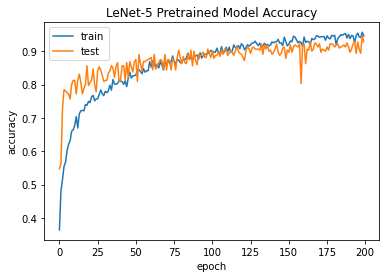

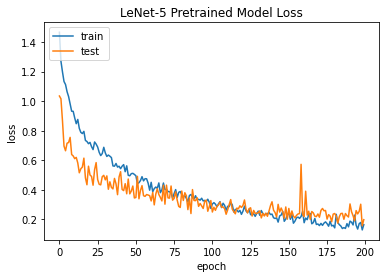

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LeNet-5 Pretrained Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LeNet-5 Pretrained Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
%%time
model.evaluate(testing_generator)

7/7 [==============================] - 2s 222ms/step - loss: 0.1932 - accuracy: 0.9415
Wall time: 2.18 s


[0.19320033490657806, 0.9414634108543396]

# Predict Test (PRETRAINED

In [35]:
load_model = keras.models.load_model(r'C:\Users\Julius Chris\Desktop\skripsi\lenet_pretuned.h5')

In [36]:
%%time
load_model.evaluate(testing_generator)

7/7 [==============================] - 1s 208ms/step - loss: 0.2045 - accuracy: 0.9366
Wall time: 2.19 s


[0.20446859300136566, 0.9365853667259216]

Confusion matrix, without normalization
[[38  3  0  0  0]
 [ 0 39  0  0  2]
 [ 0  4 37  0  0]
 [ 0  0  0 41  0]
 [ 0  5  1  0 35]]
                          precision    recall  f1-score   support

            Dyskeratotic       1.00      0.93      0.96        41
            Koilocytotic       0.76      0.95      0.85        41
              Metapastic       0.97      0.90      0.94        41
               Parabasal       1.00      1.00      1.00        41
Superficial-Intermediate       0.95      0.85      0.90        41

                accuracy                           0.93       205
               macro avg       0.94      0.93      0.93       205
            weighted avg       0.94      0.93      0.93       205



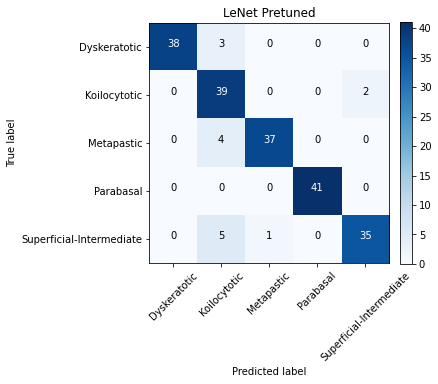

In [38]:
labels = list(testing_generator.class_indices.keys())   
y_true = testing_generator.classes
y_pred = load_model.predict_generator(testing_generator)
rounded_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true=y_true, y_pred=rounded_pred)
plot_confusion_matrix(cm, labels, title="LeNet Pretuned")
report = classification_report(y_true, rounded_pred, target_names=labels)
print(report)


# HYPERPARAMETER TUNING

In [46]:
# Create the keras tuner model.
class MyHyperModel(HyperModel):
    
    def build(self, hp):        
        model = Sequential() 
        model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)))
        model.add(MaxPool2D(strides=2))
        model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
        model.add(MaxPool2D(strides=2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(hp.Choice('dropout', values=[0.2,0.3,0.4,0.5])))
        model.add(Dense(84, activation='relu'))
        model.add(Dropout(hp.Choice('dropout', values=[0.2,0.3,0.4,0.5])))
        model.add(Dense(5, activation='softmax'))
        model.build()
        model.compile(
            optimizer=hp.Choice('optimizer', values= ['Adam', 'Adadelta', 'Adamax']),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return model

hypermodel = MyHyperModel()

tuner = BayesianOptimization(
    hypermodel,
    objective=Objective('val_accuracy', direction="max"),
    num_initial_points=50,
    max_trials=20,
    directory='./',
    project_name='lenet_hyperparameter_tuning')

tuner.search(train_generator,
             epochs=10, validation_data=validation_generator)

Trial 10 Complete [00h 06m 12s]
val_accuracy: 0.8366336822509766

Best val_accuracy So Far: 0.9026402831077576
Total elapsed time: 01h 02m 16s
INFO:tensorflow:Oracle triggered exit


In [47]:
tuner.results_summary()

Results summary
Results in ./lenet_hyperparameter_tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout: 0.2
optimizer: Adam
Score: 0.9026402831077576
Trial summary
Hyperparameters:
dropout: 0.3
optimizer: Adamax
Score: 0.8366336822509766
Trial summary
Hyperparameters:
dropout: 0.2
optimizer: Adamax
Score: 0.8366336822509766
Trial summary
Hyperparameters:
dropout: 0.4
optimizer: Adamax
Score: 0.8201320171356201
Trial summary
Hyperparameters:
dropout: 0.5
optimizer: Adamax
Score: 0.7953795194625854
Trial summary
Hyperparameters:
dropout: 0.4
optimizer: Adadelta
Score: 0.7541254162788391
Trial summary
Hyperparameters:
dropout: 0.4
optimizer: Adam
Score: 0.7343234419822693
Trial summary
Hyperparameters:
dropout: 0.3
optimizer: Adadelta
Score: 0.7161716222763062
Trial summary
Hyperparameters:
dropout: 0.3
optimizer: Adam
Score: 0.7145214676856995
Trial summary
Hyperparameters:
dropout: 0.2
optimizer: Adadelta
Score: 0.704620480

In [48]:
models = tuner.get_best_models(num_models=1)

models[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 48)      38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 139968)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               35832064  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

# AFTER TUNING MODEL

In [9]:
tuned_model = Sequential()
tuned_model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)))
tuned_model.add(MaxPool2D(strides=2))
tuned_model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
tuned_model.add(MaxPool2D(strides=2))
tuned_model.add(Flatten())
tuned_model.add(Dense(256, activation='relu'))
tuned_model.add(Dropout(0.2))
tuned_model.add(Dense(84, activation='relu'))
tuned_model.add(Dropout(0.2))
tuned_model.add(Dense(5, activation='softmax'))
tuned_model.build()
tuned_model.summary()


tuned_model.compile(keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 48)      38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 139968)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               35832064  
_________________________________________________________________
dropout (Dropout)            (None, 256)              

In [10]:
filepath = "lenet_tuned.h5"
checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list = [checkpoint]

In [11]:
%%time
history = tuned_model.fit(train_generator, 
                  steps_per_epoch=50, 
                  epochs=200,
                  validation_data=validation_generator, 
                  validation_steps=10,
                  callbacks=callbacks_list)

Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 1.3442 - accuracy: 0.4282
Epoch 00001: val_accuracy improved from -inf to 0.67188, saving model to lenet_tuned.h5
50/50 [==============================] - 20s 407ms/step - loss: 1.3442 - accuracy: 0.4282 - val_loss: 0.8815 - val_accuracy: 0.6719
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 1.1347 - accuracy: 0.5431
Epoch 00002: val_accuracy did not improve from 0.67188
50/50 [==============================] - 19s 378ms/step - loss: 1.1347 - accuracy: 0.5431 - val_loss: 1.1456 - val_accuracy: 0.5625
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 0.9990 - accuracy: 0.6237
Epoch 00003: val_accuracy improved from 0.67188 to 0.74063, saving model to lenet_tuned.h5
50/50 [==============================] - 19s 382ms/step - loss: 0.9990 - accuracy: 0.6237 - val_loss: 0.7177 - val_accuracy: 0.7406
Epoch 4/200
50/50 [==============================] - ETA: 0s - loss: 0.9637 - accurac

50/50 [==============================] - ETA: 0s - loss: 0.4250 - accuracy: 0.8539
Epoch 00028: val_accuracy did not improve from 0.87500
50/50 [==============================] - 17s 344ms/step - loss: 0.4250 - accuracy: 0.8539 - val_loss: 0.4059 - val_accuracy: 0.8438
Epoch 29/200
50/50 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8558
Epoch 00029: val_accuracy did not improve from 0.87500
50/50 [==============================] - 17s 339ms/step - loss: 0.3895 - accuracy: 0.8558 - val_loss: 0.3359 - val_accuracy: 0.8594
Epoch 30/200
50/50 [==============================] - ETA: 0s - loss: 0.4373 - accuracy: 0.8469
Epoch 00030: val_accuracy did not improve from 0.87500
50/50 [==============================] - 17s 340ms/step - loss: 0.4373 - accuracy: 0.8469 - val_loss: 0.3293 - val_accuracy: 0.8562
Epoch 31/200
50/50 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.8619
Epoch 00031: val_accuracy improved from 0.87500 to 0.87813, saving m

Epoch 57/200
50/50 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.8964
Epoch 00057: val_accuracy did not improve from 0.90625
50/50 [==============================] - 17s 346ms/step - loss: 0.2888 - accuracy: 0.8964 - val_loss: 0.3305 - val_accuracy: 0.8781
Epoch 58/200
50/50 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9136
Epoch 00058: val_accuracy did not improve from 0.90625
50/50 [==============================] - 17s 342ms/step - loss: 0.2645 - accuracy: 0.9136 - val_loss: 0.3073 - val_accuracy: 0.8844
Epoch 59/200
50/50 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.9156
Epoch 00059: val_accuracy did not improve from 0.90625
50/50 [==============================] - 17s 343ms/step - loss: 0.2498 - accuracy: 0.9156 - val_loss: 0.2774 - val_accuracy: 0.8906
Epoch 60/200
50/50 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9069
Epoch 00060: val_accuracy did not improve from 0.90625


Epoch 86/200
50/50 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9150
Epoch 00086: val_accuracy did not improve from 0.91250
50/50 [==============================] - 19s 377ms/step - loss: 0.2297 - accuracy: 0.9150 - val_loss: 0.3211 - val_accuracy: 0.8906
Epoch 87/200
50/50 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9288
Epoch 00087: val_accuracy did not improve from 0.91250
50/50 [==============================] - 17s 342ms/step - loss: 0.2066 - accuracy: 0.9288 - val_loss: 0.2817 - val_accuracy: 0.8906
Epoch 88/200
50/50 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9358
Epoch 00088: val_accuracy did not improve from 0.91250
50/50 [==============================] - 17s 341ms/step - loss: 0.1871 - accuracy: 0.9358 - val_loss: 0.2956 - val_accuracy: 0.8844
Epoch 89/200
50/50 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9263
Epoch 00089: val_accuracy did not improve from 0.91250


Epoch 115/200
50/50 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9575
Epoch 00115: val_accuracy did not improve from 0.92813
50/50 [==============================] - 17s 348ms/step - loss: 0.1344 - accuracy: 0.9575 - val_loss: 0.3433 - val_accuracy: 0.8844
Epoch 116/200
50/50 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9556
Epoch 00116: val_accuracy did not improve from 0.92813
50/50 [==============================] - 17s 348ms/step - loss: 0.1191 - accuracy: 0.9556 - val_loss: 0.2789 - val_accuracy: 0.9062
Epoch 117/200
50/50 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9549
Epoch 00117: val_accuracy did not improve from 0.92813
50/50 [==============================] - 17s 346ms/step - loss: 0.1274 - accuracy: 0.9549 - val_loss: 0.2814 - val_accuracy: 0.8969
Epoch 118/200
50/50 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9352
Epoch 00118: val_accuracy did not improve from 0.92

Epoch 144/200
50/50 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9638
Epoch 00144: val_accuracy did not improve from 0.93750
50/50 [==============================] - 17s 335ms/step - loss: 0.1109 - accuracy: 0.9638 - val_loss: 0.2757 - val_accuracy: 0.9187
Epoch 145/200
50/50 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9600
Epoch 00145: val_accuracy did not improve from 0.93750
50/50 [==============================] - 17s 343ms/step - loss: 0.1136 - accuracy: 0.9600 - val_loss: 0.1984 - val_accuracy: 0.9281
Epoch 146/200
50/50 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9644
Epoch 00146: val_accuracy did not improve from 0.93750
50/50 [==============================] - 17s 338ms/step - loss: 0.1110 - accuracy: 0.9644 - val_loss: 0.2510 - val_accuracy: 0.9062
Epoch 147/200
50/50 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9682
Epoch 00147: val_accuracy did not improve from 0.93

Epoch 173/200
50/50 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9695
Epoch 00173: val_accuracy did not improve from 0.93750
50/50 [==============================] - 18s 355ms/step - loss: 0.0777 - accuracy: 0.9695 - val_loss: 0.2581 - val_accuracy: 0.9312
Epoch 174/200
50/50 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9803
Epoch 00174: val_accuracy did not improve from 0.93750
50/50 [==============================] - 17s 341ms/step - loss: 0.0584 - accuracy: 0.9803 - val_loss: 0.2014 - val_accuracy: 0.9281
Epoch 175/200
50/50 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9733
Epoch 00175: val_accuracy did not improve from 0.93750
50/50 [==============================] - 17s 338ms/step - loss: 0.0763 - accuracy: 0.9733 - val_loss: 0.2397 - val_accuracy: 0.9187
Epoch 176/200
50/50 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9819
Epoch 00176: val_accuracy did not improve from 0.93

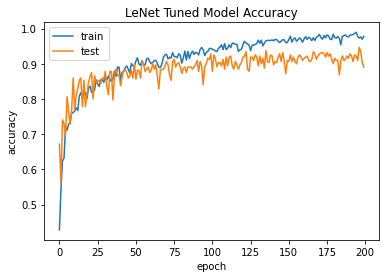

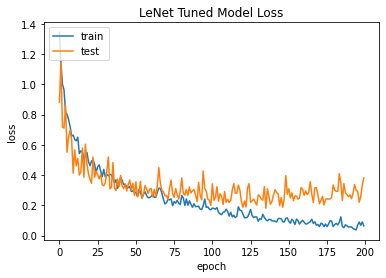

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LeNet Tuned Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LeNet Tuned Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
tuned_model = keras.models.load_model(r'C:\Users\Julius Chris\Desktop\skripsi\lenet_tuned.h5')

In [16]:
%%time
tuned_model.evaluate(testing_generator)

7/7 [==============================] - 2s 285ms/step - loss: 0.1204 - accuracy: 0.9659
Wall time: 2.76 s


[0.12035816162824631, 0.9658536314964294]

Confusion matrix, without normalization
[[39  2  0  0  0]
 [ 0 39  1  0  1]
 [ 0  2 39  0  0]
 [ 0  0  0 41  0]
 [ 0  1  0  1 39]]
                          precision    recall  f1-score   support

            Dyskeratotic       1.00      0.95      0.97        41
            Koilocytotic       0.89      0.95      0.92        41
              Metapastic       0.97      0.95      0.96        41
               Parabasal       0.98      1.00      0.99        41
Superficial-Intermediate       0.97      0.95      0.96        41

                accuracy                           0.96       205
               macro avg       0.96      0.96      0.96       205
            weighted avg       0.96      0.96      0.96       205



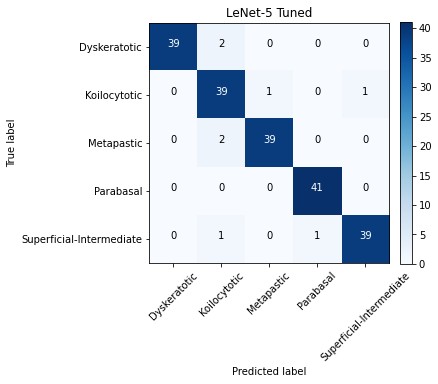

In [19]:
labels = list(testing_generator.class_indices.keys())   
y_true = testing_generator.classes
y_pred = tuned_model.predict_generator(testing_generator)
rounded_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true=y_true, y_pred=rounded_pred)
plot_confusion_matrix(cm, labels, title="LeNet-5 Tuned")
report = classification_report(y_true, rounded_pred, target_names=labels)
print(report)
